# Project 3: Fraud Detection

In this third project, the main objective is to develop a fraud detection model capable of predicting fraudulent bank transactions. The implementation places particular emphasis on the following key areas:
- Unsupervised learning
- Semi-supervised learning
- Dealing with class imbalance
- Using advanced performance metrics to evaluate detection models under different inspection effort thresholds.

## Problem Understanding

The subject of fraud has always been a problem for the financial sector and with the ongoing technological advance, the problem will only increase. According to the [ Alloy’s 2024 State of Fraud Benchmark Report](https://www.alloy.com/state-of-fraud-benchmark-report-2024), which has asked more than 400 descision-makers in fraud-related roles, 57% of banks, fintechs, and credit unions lost over $500K in direct fraud losses in 2023. These figures reflect only the direct losses from fraud. That is, the actual amounts successfully stolen through fraudulent activity. 

In the UK, 10% of companies have lost between €1 and €100,000; 26% between €100,001 and €500,000; 34% between €500,001 and €1,000,000; 24% between €1,000,001 and €10,000,000; and 1% have suffered losses exceeding €10,000,000 due to fraud. Only 7 % reported no fraud loss, or simply don't know if they have.

Around 60% of the respondents reported an increase in the number of fraud attempts in consumer accounts compared to the previous year. Meanwhile, just over half the respondends have reported an increase in fraud attempts in business accounts.

The [UK Finance Annual Fraud Report 2022](https://www.ukfinance.org.uk/system/files/2023-05/Annual%20Fraud%20Report%202023_0.pdf) reported a net total loss £1.2 bn across the collective banking and finance industry in 2022 alone. This shows the damaging effects of fraud and emphazises the importance of fraud detection to prevent the enormous amounts of anual loss.

While the field has developed rapidly in the last few years, especially through the rise of artificial intelligence, there are still some challenges for successful fraud detection models. According to this article by the [Computer Science & IT Research Journal](https://fepbl.com/index.php/csitrj/article/view/1252), one major issue is the quality of datasets, especially due to the imbalance between fraudulent and legitimate activities, which can lead to biased or inaccurate predictions. Additionally, datasets suffer limited diversity or hidden biases, which skew model performances and undermine fairness. 

Overall, the problem of fraud and the importance of dealing with it through fraud detection systems is clear. The following sections of this notebook will focus on explring the data, understanding how to deal with class imbalance, as well as building and evaluating a fraud detection system using advanced techniques using unsupervised and semi-supervised learning.

In [14]:
# Includes
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Understanding the Data

The first thing to do is to take a closer look at the data that will be used to train the model later. Then, the data will be split into a test-train-val split before any further analysis.

In [2]:
# Load data
df = pd.read_csv("data/sales.csv")
df = df.set_index('Unnamed: 0') # set index
df.index.name = None
df

,ID,Prod,Quant,Val,Insp
1,v1,p1,182.0,1665.0,unkn
2,v2,p1,3072.0,8780.0,unkn
3,v3,p1,20393.0,76990.0,unkn
4,v4,p1,112.0,1100.0,unkn
5,v3,p1,6164.0,20260.0,unkn
...,...,...,...,...,...
411814,v5918,p4126,113.0,9330.0,unkn
411815,v2540,p4126,118.0,3355.0,unkn
411816,v5896,p4127,143.0,1835.0,unkn
411817,v1796,p4127,102.0,1445.0,unkn


In [ ]:
# # Seperate labeled and unlabeled data
# labeled_df = df[df["Insp"].isin(["ok", "fraud"])].copy()
# unlabeled_df = df[df["Insp"] == "unkn"].copy()

# labeled_df

# # Split into X and y
# X = labeled_df.drop(columns="Insp")
# y = labeled_df["Insp"].map({"ok": 0, "fraud": 1})  # convert to binary

# # Split into train/test
# X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(
#     X,
#     y,
#     test_size=0.25,
#     random_state=123,
#     stratify=y
# )

# use later during self supervised training

Before doing anything with the data, we split them into train and test set to prevent bias:

In [95]:
y = df["Insp"]
X = df.drop(labels=["Insp"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=123,
    stratify=y
)

In [97]:
y_train.unique()

array(['unkn', 'ok', 'fraud'], dtype=object)

In [98]:
print("Amount of unique vendors: ", len(X_train["ID"].unique()))
print("Amount of unique products: ", len(X_train["Prod"].unique()))

Amount of unique vendors:  5955
Amount of unique products:  4548


The data shows around 6000 unique vendors and around 4500 unique products. This makes it harder to encode the values for the model training phase.

In [99]:
X_train.isnull().any()

ID       False
Prod     False
Quant     True
Val       True
dtype: bool

In [100]:
null_rows = X_train[X_train.isnull().any(axis=1)]
null_rows

,ID,Prod,Quant,Val
342516,v614,p3478,NaN,1015.0
386456,v2694,p2126,NaN,1285.0
202471,v1981,p3164,NaN,1240.0
169552,v891,p3871,NaN,1035.0
302068,v1141,p1471,NaN,NaN
...,...,...,...,...
106715,v426,p2909,NaN,1015.0
93131,v1136,p1915,NaN,1020.0
197437,v819,p2693,NaN,1040.0
273015,v431,p3928,NaN,1065.0


The data contains 10586 rows with NaN in either the quantity or value column. This is only a small portion of the data, therefore they could safely be removed. Despite that, the values could be estimated instead. For now, let's create a copy of the data with removed values and keep the dataframe including the NaN values too.

In [ ]:
X_train_cleaned = X_train.dropna() # clean just in case

In [102]:
X_train.isnull().sum()[X_train.isnull().sum() > 0]

Quant    10368
Val        881
dtype: int64

In [103]:
rows_with_multiple_nulls = X_train.isnull().sum(axis=1)
num_rows = (rows_with_multiple_nulls >= 2).sum()
print(f"{num_rows} rows have missing values in two or more columns.")

663 rows have missing values in two or more columns.


NaN values seem to be more prevelant in the quantity column than in the value column, and with 663 rows with missing values in both column, most missing Val columns are also missing the quantity value. 

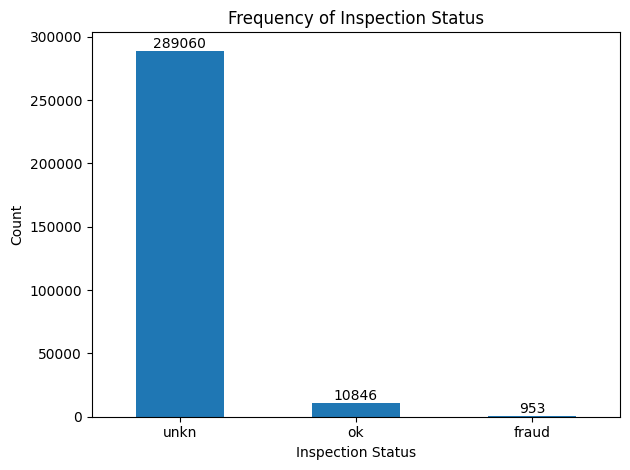

In [105]:
counts = y_train.value_counts() # get value counts for each unique "Insp" value

ax = counts.plot(kind="bar") # create plot

plt.xlabel("Inspection Status")
plt.ylabel("Count")
plt.title("Frequency of Inspection Status")
plt.xticks(rotation=0)

# plot actual values
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


The data is consists of a transaction Id("ID"), the products("Prod") bought with a quantity("Quant") and a the corresponding value("Val") spent during the transaction. For training, the id will not be necessary, but the rest can be used for preictions. A inspected value("Insp") flags the transaction as 'ok', 'fraud', or as 'unknown'. When looking at the value distribution, it can be seen that there is a significant amount of unknown data, and a small amount of data that is actually flagged as okay or fraudulent. This data imbalance needs to be addressed later.


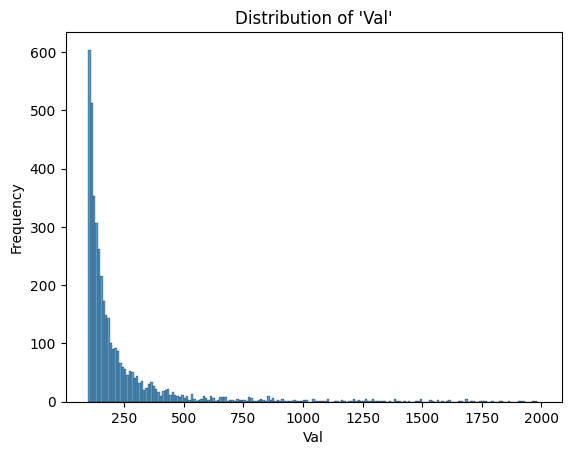

In [111]:
# val distribution
sns.histplot(X_train["Val"] / X_train["Quant"], bins=range(100, 2000, 10))
plt.title("Distribution of 'Val'")
plt.xlabel("Val")
plt.ylabel("Frequency")
plt.show()

The value distribution exposes strong tailed skewness to the left, which makes it harder to read this plot. This is to be expected, as in a real life scenario, smaller transactions are more common than larger ones. Apart from the value distribution, the quantity distribution looks like this:

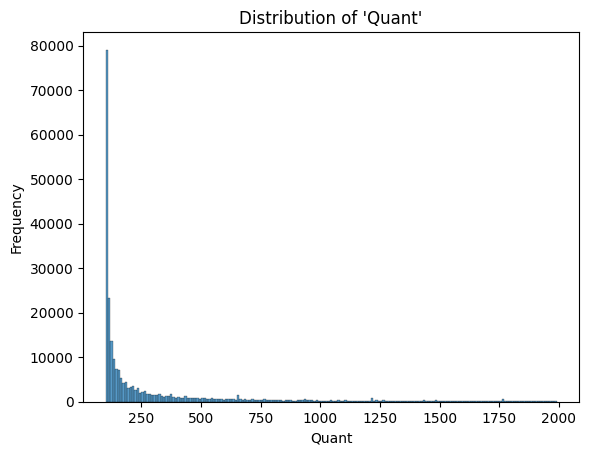

In [112]:
# quant distribution
sns.histplot(X_train["Quant"], bins=range(100, 2000, 10))
plt.title("Distribution of 'Quant'")
plt.xlabel("Quant")
plt.ylabel("Frequency")
plt.show()

The quantity distribution shows similar results to the value distribution, it is highly skewed to the left side. Overall, the skewness is not necessarily bad, as it represents real life circumstances. Despite that, removing the skewness could still be considered in case of bad prediction performance later.

Now let's look at the number of transactions per vendor as well as per product:

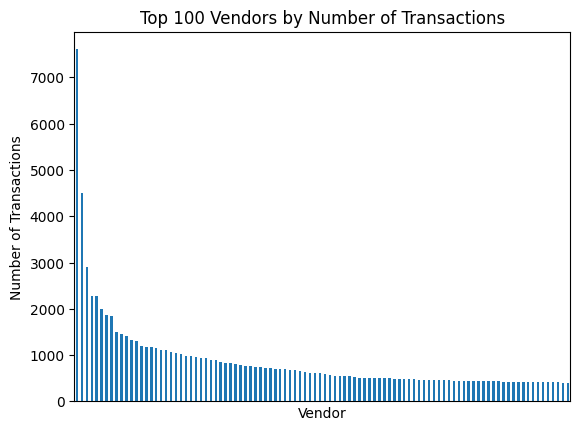

In [113]:
# transactions per vendor
vendor_counts = X_train.groupby("ID").size().sort_values(ascending=False)

# plot
vendor_counts.head(100).plot(kind="bar")
plt.title("Top 100 Vendors by Number of Transactions")
plt.ylabel("Number of Transactions")
plt.xlabel("Vendor")
plt.xticks([], [])  # remove massive amount of ticks
plt.xticks(rotation=45)
plt.show()

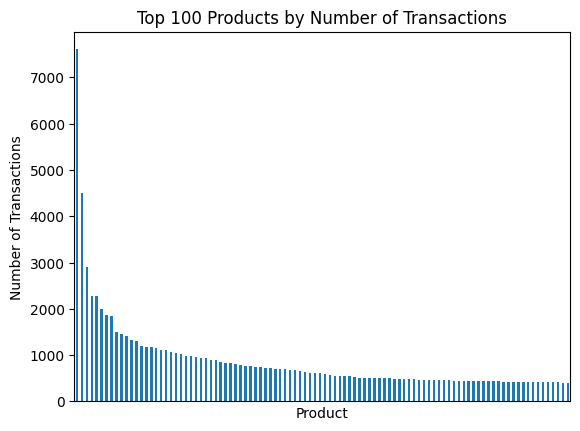

In [114]:
# transactions per product
prod_counts = X_train.groupby("Prod").size().sort_values(ascending=False)

# plot
vendor_counts.head(100).plot(kind="bar")
plt.title("Top 100 Products by Number of Transactions")
plt.ylabel("Number of Transactions")
plt.xlabel("Product")
plt.xticks([], [])  # remove massive amount of ticks
plt.xticks(rotation=45)
plt.show()

Plotting the top 100 vendors/products by number of transactions reveals long tailed skewness again, just like before during the value and quantity distribution. This is again applicable for real life scenario, where a small percentage of customers make far more transactions than the rest. Although this data represents a real life scenario, it could lead to some problems later, during the semi-supervised learning approaches. Training the model on data that is heavily skewed towards a small amount of costumers may have a strong bias towards them. Therefore, some pre-processing will be necessary in order to prevent this from happening.

## Data Grouping and Feature Engineering

In this section, some data grouping and feature engineering is performed before training a model. Due to the fact that there are so many differnet products present in the data, grouping transactions per product might improve prediction quality.

In [110]:
X_train['Uprice'] = X_train['Val'] / X_train['Quant']

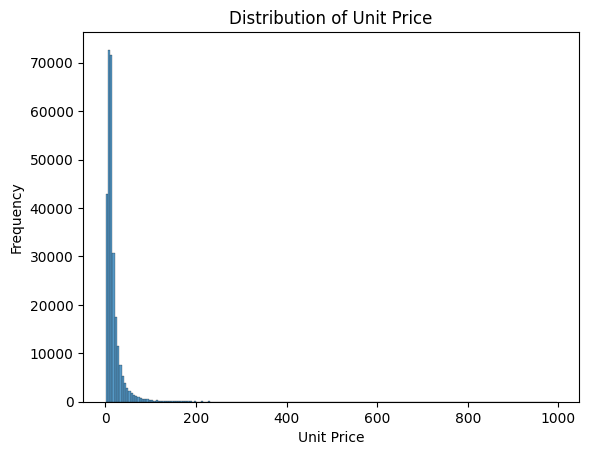

In [134]:
# plot
sns.histplot(X_train["Uprice"], bins=range(1,1000,5))
plt.title("Distribution of Unit Price")
plt.xlabel("Unit Price")
plt.ylabel("Frequency")
plt.show()

## Semi-Supervised Learning Approaches


In this section, some semi-supervised learning techniques are implemented, that try to deal with the problem of inbalance in the data. To start things off, a self supervised training is used. In this approach, a model is trained only on the labeled data that is available. After that, the most confident predictions will be added to the labeled data. This way, new labeled data can be created, which makes the model more balanced. Now let's start with a random forest model as baseline.

In [15]:
threshhold = 0.95 # 95% confidence threshhold for predictions

rf = RandomForestClassifier(n_estimators=100, random_state=123)
rf.fit(X_train_labeled, y_train_labeled) # train on labeled data

pred = rf.predict_proba(unlabeled_df[X.columns])[:, 1] # predict unlabeled data 

ValueError: could not convert string to float: 'v1081'